In [70]:
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm, inv
from scipy.stats import unitary_group

In [61]:
def xx_to_xp(S, r):
    """
    Converts S and r from non-interleaved (x1...xm, p1...pm) 
    to interleaved (x1, p1, ..., xm, pm) ordering.
    """
    dim = S.shape[0]
    m = dim // 2
    
    # 1. Create the permutation index array
    # This creates: [0, m, 1, m+1, 2, m+2, ..., m-1, 2m-1]
    perm = np.empty(dim, dtype=int)
    perm[0::2] = np.arange(m)      # Even indices get the first m elements (x)
    perm[1::2] = np.arange(m, dim) # Odd indices get the last m elements (p)
    
    # 2. Permute the displacement vector r
    r_xp = r[perm]
    
    # 3. Permute the symplectic matrix S
    # We must apply the permutation to both rows and columns
    S_xp = S[perm, :][:, perm]
    
    return S_xp, r_xp

# Gaussian State

In [2]:
class GaussianState:
    """
    Represents an m-mode Gaussian state. [cite: 239]
    
    Attributes:
        m (int): The number of modes. [cite: 237, 238]
        mean (np.ndarray): First-moment vector in R^{2m}. 
        cov (np.ndarray): Covariance matrix in R^{2m x 2m}. 
    """
    def __init__(self, mean, cov):
        # Ensure the mean is a 1D array and the covariance is a 2D array
        self.mean = np.array(mean, dtype=np.float64).flatten()
        self.cov = np.array(cov, dtype=np.float64)
        
        # Determine dimension and number of modes
        # The phase space dimension is 2m [cite: 242, 247]
        self.dim = len(self.mean)
        if self.dim % 2 != 0:
            raise ValueError("The mean vector must have an even dimension (2m).")
            
        if self.cov.shape != (self.dim, self.dim):
            raise ValueError(f"Covariance matrix must be {self.dim}x{self.dim}.")
            
        self.m = self.dim // 2 

    def __repr__(self):
        return f"GaussianState(modes={self.m}, mean_norm={self.mean})"

    @classmethod
    def coherent(cls, m_modes, mean_vector=None):
        """
        Creates an m-mode coherent state.
        
        Args:
            m_modes (int): Number of modes for the state 
            mean_vector (np.ndarray, optional): A 2m-dimensional vector 
                representing the displacement (x1, p1, ..., xm, pm). 
                If None, creates a vacuum state.
        """
        dim = 2 * m_modes
        
        # If no mean vector is provided, default to the vacuum state (zero mean) 
        if mean_vector is None:
            mean = np.zeros(dim)
        else:
            mean = np.array(mean_vector, dtype=np.float64)
            if len(mean) != dim:
                raise ValueError(f"Mean vector must have length {dim} for {m_modes} modes.")
        
        # Coherent states always have a covariance matrix equal to the identity 
        cov = np.eye(dim)
        
        return cls(mean, cov)
        
    def mean_photon_number(self):
        """
        Computes the mean photon number (energy) of the Gaussian state.
        Based on Eq. (2.23) from the paper.
        """
        # Term 1: (Tr(V) - Tr(I)) / 4
        # Note: Tr(I) for a 2m x 2m matrix is simply the dimension (2m)
        trace_term = (np.trace(self.cov) - self.dim) / 4.0
        
        # Term 2: ||m||^2 / 2
        # This is the squared Euclidean norm of the mean vector divided by 2
        displacement_term = np.linalg.norm(self.mean)**2 / 2.0
        
        return trace_term + displacement_term

    def measure_heterodyne(self, num_meas=1):
        """
        Simulates heterodyne measurement on the Gaussian state.
        
        Args:
            num_meas (int): The number of independent measurement samples to generate.
            
        Returns:
            np.ndarray: An array of shape (num_meas, 2m) containing the classical 
                        outcomes for each measurement.
        """
        # Define the heterodyne covariance matrix: (V + I) / 2
        het_cov = (self.cov + np.eye(self.dim)) / 2.0
        
        # Generate num_meas samples from the multivariate normal distribution
        # defined by the state's mean and the heterodyne covariance.
        samples = np.random.multivariate_normal(
            mean=self.mean, 
            cov=het_cov, 
            size=num_meas
        )
        
        return samples

# Gaussian Unitary

In [83]:
class GaussianUnitary:
    """
    Represents a bosonic Gaussian unitary G = Dr * Us.
    
    Attributes:
        m (int): Number of modes.
        dim (int): Phase-space dimension (2 * m).
        S (np.ndarray): 2m x 2m real symplectic matrix.
        r (np.ndarray): 2m-dimensional real displacement vector.
    """
    def __init__(self, S, r):
        # The phase-space dimension is determined by the size of the symplectic matrix 
        self.dim = S.shape[0]
        
        # Verify that the matrix is square and the displacement vector matches its size
        if S.shape[0] != S.shape[1]:
            raise ValueError("Symplectic matrix S must be square.")
        if len(r) != self.dim:
            raise ValueError(f"Displacement vector r must have dimension {self.dim}.")
        if self.dim % 2 != 0:
            raise ValueError("Phase-space dimension must be even (2 * m).")
            
        self.S = np.array(S, dtype=np.float64)
        self.r = np.array(r, dtype=np.float64)
        self.m = self.dim // 2

    def __repr__(self):
        return f"GaussianUnitary(modes={self.m}, dim={self.dim})\n\nS = {self.S}\n\nr = {self.r}"

    def is_symplectic(self, tol=1e-9):
        """
        Checks if the stored matrix S is actually symplectic.
        
        Args:
            tol (float): Numerical tolerance for the comparison.
            
        Returns:
            bool: True if S is symplectic, False otherwise.
        """
        # 1. Construct the canonical symplectic form Omega
        # Omega = \bigoplus_{i=1}^{m} [[0, 1], [-1, 0]]
        omega_block = np.array([[0, 1], [-1, 0]])
        Omega = np.zeros((self.dim, self.dim))
        for i in range(self.m):
            Omega[2*i:2*i+2, 2*i:2*i+2] = omega_block
            
        # 2. Check the condition: S^T @ Omega @ S == Omega
        # We use np.allclose for numerical stability
        left_side = self.S.T @ Omega @ self.S
        
        return np.allclose(left_side, Omega, atol=tol)
    
    @classmethod
    def random(cls, m, z):
        """
        Constructs a random Gaussian Unitary using Bloch-Messiah decomposition.
        S = O1 * Zs * O2 in interleaved (x1, p1, x2, p2...) ordering.
        """
        def get_random_orthogonal_symplectic(m_modes):
            """
            Creates a random passive transformation by embedding a Haar-random 
            complex unitary U = X + iY into a 2m x 2m real matrix.
            """
            # Sample a Haar-random complex unitary matrix
            U = unitary_group.rvs(m_modes)
            X = U.real
            Y = U.imag
            
            # Create the 2m x 2m interleaved matrix
            # For each mode pair, the complex multiplication (X+iY)(x+ip) 
            # maps to [[X, -Y], [Y, X]] in the real xp-space.
            O = np.zeros((2 * m_modes, 2 * m_modes))
            for i in range(m_modes):
                for j in range(m_modes):
                    # Setting the 2x2 blocks for interleaved ordering
                    block = np.array([[X[i, j], -Y[i, j]],
                                      [Y[i, j],  X[i, j]]])
                    O[2*i:2*i+2, 2*j:2*j+2] = block
            return O

        # 1. Generate two random passive interferometers O1 and O2
        O1 = get_random_orthogonal_symplectic(m)
        O2 = get_random_orthogonal_symplectic(m)
        
        # 2. Generate squeezing parameters z_j such that 1 <= z_j <= z
        # We set the first one to exactly z to saturate the bound ||S||_inf = z
        z_vals = np.random.uniform(1.0, z, m)
        z_vals[0] = z
        
        # 3. Construct the diagonal squeezing matrix Zs (interleaved)
        # Zs = diag(z1, 1/z1, z2, 1/z2, ...)
        Zs = np.zeros((2 * m, 2 * m))
        for j in range(m):
            Zs[2*j, 2*j] = z_vals[j]
            Zs[2*j+1, 2*j+1] = 1.0 / z_vals[j]
            
        # 4. Compose the full symplectic matrix S = O1 @ Zs @ O2
        # This satisfies S^T Omega S = Omega in xp-ordering [cite: 332]
        S_paper = O1 @ Zs @ O2
        
        # 5. Generate random displacement r in R^{2m}
        r_paper = np.random.normal(0, 1, 2 * m)
        
        return cls(S_paper, r_paper)

    def evolve(self, state):
        """
        Applies this Gaussian unitary to a GaussianState object.
        Returns a new GaussianState with updated mean and covariance.
        """
        if state.m != self.m:
            raise ValueError(f"State modes ({state.m}) must match unitary modes ({self.m}).")

        # 1. Update the first moment (mean): m' = Sm + r
        # Based on Eq. (2.9) and (2.11) in the paper
        new_mean = self.S @ state.mean + self.r

        # 2. Update the second moment (covariance): V' = S V S^T
        # Based on Eq. (2.10) and (2.12) in the paper
        new_cov = self.S @ state.cov @ self.S.T

        return GaussianState(new_mean, new_cov)

    def estimate_displacement(self, num_meas):
        """
        Estimates the displacement vector r of the unknown unitary 
        using vacuum probes and heterodyne detection.
        
        Based on Section 4.1 (Vacuum-shared inputs) of the paper.
        """
        # 1. Prepare an m-mode vacuum state (a coherent state with zero mean)
        vacuum_probe = GaussianState.coherent(self.m, mean_vector=None)
        
        # 2. Apply the unknown unitary (self) to the vacuum probe
        # The output state mean will be centered at the displacement vector r
        output_state = self.evolve(vacuum_probe)
        
        # 3. Perform num_meas heterodyne measurements
        # Outcomes are distributed as N(r, (SS^T + I)/2)
        measurements = output_state.measure_heterodyne(num_meas=num_meas)
        
        # 4. Calculate the empirical mean to estimate r
        # As per Algorithm 1, Step 3 and Lemma 4.1
        r_estimate = np.mean(measurements, axis=0)
        
        return r_estimate

    def estimate_symplectic(self, displacement_est, meas_per_col, eta=1.0):
        """
        Estimates the symplectic matrix S using the vacuum-shared input protocol.
        
        Args:
            displacement_est (np.ndarray): The average heterodyne outcome from 
                the vacuum probe (the result of estimate_displacement).
            meas_per_col (int): Number of heterodyne shots per basis vector (Ns).
            eta (float): The probe amplitude for the coherent states.
            
        Returns:
            np.ndarray: A 2m x 2m estimate of the symplectic matrix S.
        """
        # Initialize an empty matrix for the estimate S_hat
        # The dimension is 2m x 2m 
        S_hat = np.zeros((self.dim, self.dim))
        
        # Iterate through each column of the phase space (2m columns)
        for i in range(self.dim):
            # 1. Create a "one-hot" mean vector: eta * e_i [cite: 478]
            one_hot_mean = np.zeros(self.dim)
            one_hot_mean[i] = eta
            
            # 2. Prepare the coherent probe state |eta * e_i> 
            probe_state = GaussianState.coherent(self.m, mean_vector=one_hot_mean)
            
            # 3. Apply the unknown unitary to the probe 
            transformed_state = self.evolve(probe_state)
            
            # 4. Perform heterodyne detection to get Y_i
            measurements = transformed_state.measure_heterodyne(num_meas=meas_per_col)
            Y_i_bar = np.mean(measurements, axis=0)
            
            # 5. Construct the i-th column estimator
            # S_hat_i = (Y_i_bar - displacement_baseline) / eta
            S_hat[:, i] = (Y_i_bar - displacement_est) / eta
            
        return S_hat

    def estimate_unitary(self, num_meas):
        """
        Estimate displacement and symplectic components of unitary using previous methods
        """

        r_hat = self.estimate_displacement(num_meas)
        S_hat = self.estimate_symplectic(r_hat, num_meas)

        return GaussianUnitary(S_hat, r_hat)

    def regularize(self):
        """
        Enforces exact symplecticity on the current S matrix and returns 
        a new regularized GaussianUnitary object.
        
        Based on Section 4.3: Symplectic Regularization.
        """
        # 1. Construct the canonical symplectic form Omega for m modes
        # Omega = block_diag([[0, 1], [-1, 0]], ..., [[0, 1], [-1, 0]])
        omega_block = np.array([[0, 1], [-1, 0]])
        Omega = np.zeros((self.dim, self.dim))
        for i in range(self.m):
            Omega[2*i:2*i+2, 2*i:2*i+2] = omega_block
            
        # 2. Compute T = -Omega @ S^T @ Omega @ S
        # If the matrix is already symplectic, T will be the identity.
        T = -Omega @ self.S.T @ Omega @ self.S
        
        # 3. Compute the principal square root Q = sqrt(T)
        # The paper notes this exists if S_est is sufficiently close to S.
        Q = sqrtm(T)
        
        # Numerical safety: ensure Q is real
        if np.iscomplexobj(Q):
            Q = Q.real
            
        # 4. Compute S_tilde = Q^-1 @ S
        # This matrix S_tilde is guaranteed to be symplectic.
        S_tilde = inv(Q) @ self.S
        
        # Return a new GaussianUnitary object with the regularized S and original r
        return GaussianUnitary(S_tilde, self.r)

# Benchmarking

In [117]:
def error_vs_meas(G, meas_arr, num_trials):
    """
    Analyzes the scaling of symplectic estimation error vs measurement count
    with error bars representing the standard deviation across trials.
    """
    raw_errors = np.zeros((len(meas_arr), num_trials))
    reg_errors = np.zeros((len(meas_arr), num_trials))
    
    for i, num_meas in enumerate(meas_arr):
        for trial in range(num_trials):
            # 1. Estimate displacement baseline (vacuum probe)
            # This is Step 3 in Algorithm 1 [cite: 1075]
            r_hat = G.estimate_displacement(num_meas)
            
            # 2. Estimate S_hat using coherent probes |eta e_i>
            # This is Step 4-6 in Algorithm 1 [cite: 1075]
            S_hat = G.estimate_symplectic(displacement_est=r_hat, meas_per_col=num_meas)
            
            # 3. Raw error calculation (operator norm error [cite: 95])
            raw_err = np.linalg.norm(S_hat - G.S, ord=np.inf)
            raw_errors[i, trial] = raw_err
            
            # 4. Symplectic Regularization (Algorithm 1, Step 7 [cite: 1075])
            # Uses the matrix square root correction Q [cite: 119, 120]
            G_temp = GaussianUnitary(S_hat, r_hat)
            G_reg = G_temp.regularize()
            
            # 5. Regularized error calculation
            reg_err = np.linalg.norm(G_reg.S - G.S, ord=np.inf)
            reg_errors[i, trial] = reg_err
            
    # Calculate means and standard deviations
    mean_raw = np.mean(raw_errors, axis=1)
    std_raw = np.std(raw_errors, axis=1)
    
    mean_reg = np.mean(reg_errors, axis=1)
    std_reg = np.std(reg_errors, axis=1)
    
    # Generate the log-log plot with error bars
    plt.figure(figsize=(10, 7))
    
    # Plotting raw errors
    plt.errorbar(meas_arr, mean_raw, yerr=std_raw, fmt='o-', capsize=5, 
                 label='Empirical Estimate ($\hat{S}$)', alpha=0.8)
    
    # Plotting regularized errors
    plt.errorbar(meas_arr, mean_reg, yerr=std_reg, fmt='s--', capsize=5, 
                 label='Regularized Estimate ($\\tilde{S}$)', alpha=0.8)
    
    # Reference line for 1/sqrt(N) scaling [cite: 111, 211]
    plt.loglog(meas_arr, mean_raw[0] * np.sqrt(meas_arr[0]/meas_arr), 
               'k:', alpha=0.5, label='Theoretical $1/\sqrt{N_S}$ scaling')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Measurements per Probe ($N_S$)')
    plt.ylabel('Infinity Norm Error ($||S_{est} - S||_{\infty}$)')
    plt.title('Symplectic Learning Error: Scaling and Variance')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.show()

    return raw_errors, reg_errors

In [118]:
# Example usage:
# m = 3 modes, squeezing bound z = 2.0
z = 2
G = GaussianUnitary.random(2, z)

print(f"Symplectic Matrix S (shape {G.S.shape}):\n{G.S}")
print(f"\nDisplacement Vector r:\n{G.r}")
np.linalg.norm(G.S, ord=np.inf)

Symplectic Matrix S (shape (4, 4)):
[[-0.35130613 -0.10208323 -0.75631643 -0.39408465]
 [ 0.58109872  0.42164628  1.5759155  -0.61847443]
 [-0.15698138 -0.70829773 -0.09703081  0.25725451]
 [ 1.28745025 -1.12693871  0.06872207  0.73303956]]

Displacement Vector r:
[ 1.65370636 -0.39276382 -0.82138641  0.31858056]


np.float64(3.2161505858910138)

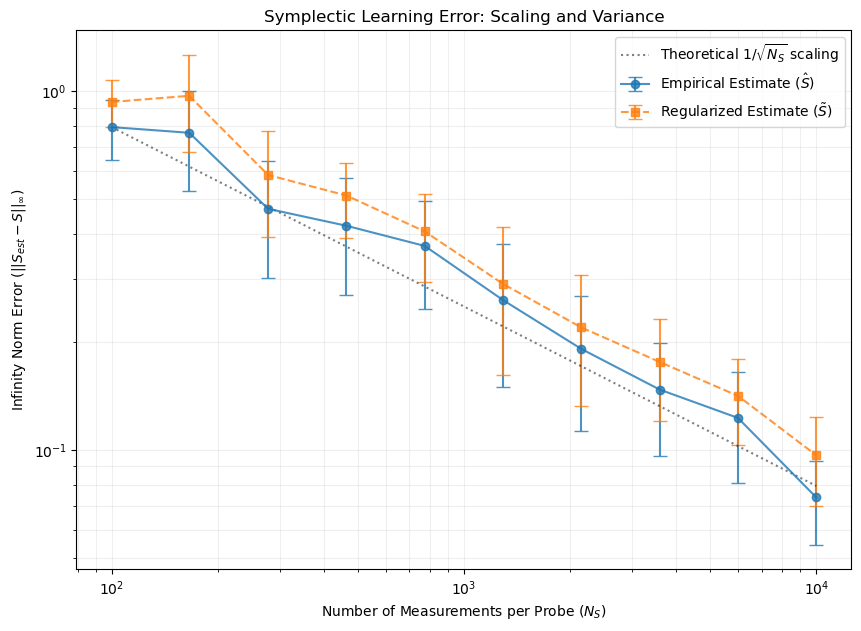

(array([[0.86418369, 0.8716809 , 0.7444768 , 0.92905006, 0.56570365,
         0.82056795, 0.65213968, 0.95973677, 0.9723314 , 0.53743973,
         1.11261445, 0.93135817, 0.62695738, 0.75044754, 0.69014366,
         0.79873829, 0.64350292, 0.73747239, 0.9692567 , 0.70859207],
        [0.83649409, 0.70781653, 0.50523749, 0.54560437, 0.5302608 ,
         0.62478415, 0.64747043, 0.68609903, 0.68273458, 1.35642085,
         0.76508816, 0.58278612, 1.15847284, 1.19296454, 1.03526315,
         0.73585557, 0.65891298, 0.55164084, 0.59218739, 0.92345366],
        [0.34201014, 0.41308078, 0.42178701, 0.25366156, 0.26172008,
         0.64583325, 0.89145878, 0.51355923, 0.80829001, 0.41857521,
         0.38435053, 0.40652466, 0.36535851, 0.46436778, 0.51240016,
         0.6876495 , 0.5358137 , 0.31663104, 0.45534509, 0.3050829 ],
        [0.30332009, 0.26658067, 0.24319336, 0.64528312, 0.21707981,
         0.29566889, 0.28934706, 0.71721993, 0.44493263, 0.46515464,
         0.61377725, 0.5502469 

In [120]:
meas_arr = np.logspace(2,4,10).astype(int)
error_vs_meas(G, meas_arr, 20)

In [93]:
G_est = G.estimate_unitary(10**4)
print(G_est)
print()
print("Inf norm = ", np.linalg.norm(G_est.S - G.S, ord=np.inf), "\n")
G_reg = G_est.regularize()
print(G_reg)
print("Inf norm = ", np.linalg.norm(G_reg.S - G.S, ord=np.inf), "\n")

GaussianUnitary(modes=2, dim=4)

S = [[ 0.58239843 -0.47308069  0.40058085  0.6664931 ]
 [ 0.35993086  0.53662173 -0.09902659  1.11009454]
 [ 0.02751788  1.12235625  0.41559235 -1.02825082]
 [-0.45202239 -0.10007243  0.11306946  0.89165252]]

r = [-0.62252967  1.70797615  1.03775567  0.31873242]

Inf norm =  0.049127419445355314 

GaussianUnitary(modes=2, dim=4)

S = [[ 0.58264372 -0.47661158  0.404049    0.67728057]
 [ 0.3546672   0.5444855  -0.09544107  1.126605  ]
 [ 0.03471873  1.11156663  0.42365179 -1.02657842]
 [-0.45569673 -0.09748396  0.11097979  0.88925796]]

r = [-0.62252967  1.70797615  1.03775567  0.31873242]
Inf norm =  0.04974100182951876 



In [34]:
np.linalg.norm(G_est.S - G_reg.S, ord=np.inf)

np.float64(1.7652689360148077)